In [1]:
import os
import gc
from datetime import datetime
from importlib import reload  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score #, precision_recall_curve, roc_curve, average_precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [3]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [4]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

# Exploration

In [5]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [6]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
132996,254250,0,Revolving loans,F,N,Y,0,135000.0,450000.0,22500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
109274,226731,0,Cash loans,M,Y,Y,0,126000.0,545040.0,25537.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
32718,137919,0,Cash loans,M,Y,Y,0,99000.0,314100.0,16573.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
119560,238647,1,Cash loans,F,N,Y,0,202500.0,513531.0,26347.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
23636,127507,0,Cash loans,F,N,N,0,135000.0,540000.0,28768.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
141210,263720,0,Cash loans,F,N,Y,0,175500.0,601470.0,32760.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
271202,414404,0,Cash loans,M,N,Y,0,180000.0,770292.0,30676.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
216783,351181,0,Cash loans,F,N,Y,0,279000.0,1024636.5,36931.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
236159,373534,0,Cash loans,F,N,Y,0,112500.0,647046.0,19048.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
281931,426564,0,Revolving loans,F,Y,N,0,162000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [8]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [9]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [10]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
5376,139252,Cash loans,M,Y,Y,0,315000.0,601470.0,25614.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
18527,234594,Cash loans,F,Y,N,0,135000.0,781920.0,33259.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
36430,366613,Cash loans,M,Y,Y,0,103500.0,499221.0,25618.5,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
29961,318081,Cash loans,M,N,Y,0,112500.0,509400.0,37197.0,450000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
44987,429501,Cash loans,M,N,N,2,360000.0,135000.0,14670.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
1755,112392,Cash loans,F,Y,Y,1,225000.0,685687.5,55107.0,607500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
40343,397014,Cash loans,M,Y,Y,0,157500.0,398160.0,31585.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
9672,170305,Cash loans,F,N,Y,0,171000.0,422802.0,33534.0,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
46165,437482,Cash loans,F,N,Y,0,180000.0,761872.5,65520.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
47740,448919,Cash loans,F,N,N,1,94500.0,90000.0,10678.5,90000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1681442,278612,6657889,Closed,currency 1,-888,0,-672.0,-672.0,0.000,0,140073.30,0.00,0.0,0.0,Consumer credit,-666,NaN
744264,449482,5320337,Closed,currency 1,-2893,0,-2497.0,-2524.0,3877.605,0,39861.18,0.00,0.0,0.0,Consumer credit,-2496,NaN
1424763,332528,6738582,Active,currency 1,-90,0,214.0,NaN,0.000,0,104382.00,84888.81,0.0,0.0,Consumer credit,-14,NaN
1311182,222337,5433929,Active,currency 1,-347,0,1034.0,NaN,NaN,0,675000.00,576562.50,0.0,0.0,Credit card,-66,NaN
515137,146514,6458008,Active,currency 1,-299,0,797.0,NaN,NaN,0,121500.00,96808.50,0.0,0.0,Consumer credit,-21,4365.0
191543,244230,6256756,Active,currency 1,-418,0,681.0,NaN,NaN,0,180000.00,0.00,0.0,0.0,Credit card,-32,NaN
73515,102792,5250835,Closed,currency 1,-387,0,-83.0,-83.0,0.000,0,76455.00,0.00,0.0,0.0,Consumer credit,-83,NaN
417332,280566,5975261,Closed,currency 1,-1645,0,-733.0,-733.0,NaN,0,0.00,0.00,0.0,0.0,Credit card,-19,10624.5
687397,418827,5313654,Active,currency 1,-853,0,30941.0,NaN,NaN,0,0.00,0.00,0.0,0.0,Credit card,-26,28998.0
594802,177140,6779755,Closed,currency 1,-2634,0,-1536.0,-1536.0,NaN,0,225000.00,0.00,0.0,0.0,Consumer credit,-1090,0.0


In [12]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [13]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [14]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [15]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [16]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [17]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [18]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1167071,2032125,346059,-57,45405.765,45000,0.0,0.000,0.0,0.000,2250.00,...,45405.765,45405.765,0.0,0,0.0,0.0,13.0,Active,0,0
440172,1469520,241845,-28,138163.905,135000,0.0,2248.155,0.0,2248.155,6973.11,...,138163.905,138163.905,0.0,2,0.0,2.0,62.0,Active,0,0
220585,1701338,341345,-21,0.000,0,0.0,0.000,0.0,0.000,0.00,...,0.000,0.000,0.0,0,0.0,0.0,11.0,Active,0,0
86772,1794241,200373,-13,0.000,0,0.0,0.000,0.0,0.000,0.00,...,0.000,0.000,0.0,0,0.0,0.0,7.0,Active,0,0
214712,1280808,319832,-23,0.000,157500,0.0,0.000,0.0,0.000,0.00,...,0.000,0.000,0.0,0,0.0,0.0,66.0,Active,0,0
3579029,2661053,390252,-93,0.000,67500,NaN,0.000,NaN,NaN,NaN,...,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0
243527,2430420,227965,-14,180914.670,225000,45000.0,45000.000,0.0,0.000,4685.40,...,179569.170,179569.170,1.0,1,0.0,0.0,2.0,Active,0,0
926473,2584262,236428,-5,45706.950,45000,0.0,6110.775,0.0,6110.775,2250.00,...,45706.950,45706.950,0.0,4,0.0,4.0,47.0,Active,0,0
599512,1563349,454184,-4,1490.850,135000,0.0,1627.200,0.0,1627.200,0.00,...,1490.850,1490.850,0.0,4,0.0,4.0,7.0,Active,0,0
513871,1360401,104899,-19,0.000,450000,NaN,0.000,NaN,NaN,0.00,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [19]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
615262,1869675,276476,Revolving loans,11250.000,225000.0,225000.0,NaN,225000.0,WEDNESDAY,16,...,XNA,0.0,XNA,Card X-Sell,-106.0,-61.0,365243.0,365243.0,365243.0,0.0
1456553,2030827,241102,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1620406,2828951,197047,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
300983,1942065,290770,Consumer loans,9875.520,46800.0,43857.0,4680.0,46800.0,TUESDAY,15,...,Consumer electronics,5.0,middle,POS household with interest,365243.0,-1323.0,-1203.0,-1203.0,-1194.0,0.0
457458,2111298,262176,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
854933,2362266,178964,Consumer loans,26644.230,269550.0,238491.0,45823.5,269550.0,SATURDAY,10,...,Construction,10.0,low_normal,POS industry with interest,365243.0,-85.0,185.0,365243.0,365243.0,0.0
1392165,2595053,423866,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
126652,1197871,439463,Revolving loans,5625.000,0.0,112500.0,NaN,NaN,MONDAY,12,...,Connectivity,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1651997,1867439,270788,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,1,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
959391,1384134,165463,Cash loans,28679.265,454500.0,490495.5,NaN,454500.0,THURSDAY,12,...,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-361.0,329.0,365243.0,365243.0,1.0


In [20]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [21]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
10925090,1136798,309311,1.0,1,-1215.0,-1215.0,27084.600,27084.600
3619273,2412992,171114,1.0,11,-2204.0,-2210.0,13976.190,13976.190
12394970,2341356,449992,0.0,55,-2108.0,-2112.0,9000.000,9000.000
10717647,1906234,322530,1.0,5,-991.0,-1003.0,9945.495,9945.495
4601663,2403250,220245,0.0,30,-2738.0,-2738.0,1.845,1.845
349111,1975890,122451,0.0,12,-332.0,-332.0,11250.000,11250.000
2757345,1125169,136919,1.0,4,-2840.0,-2840.0,4870.710,4870.710
7507448,1396549,208461,1.0,19,-197.0,-221.0,6717.915,6717.915
2981200,1520584,181812,2.0,11,-267.0,-268.0,10437.750,10437.750
10377803,1285836,334874,1.0,6,-1637.0,-1646.0,9416.475,9416.475


In [22]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

In [23]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms - datascientist\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [24]:
data, y = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [25]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 380)
taille des prévisions :  (307511,)


In [26]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [27]:
(y==1).sum()

24825

In [28]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [29]:
data.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
132965,254215,1,1,0,0,0,112500.0,247500.0,12375.0,247500.0,...,NaN,NaN,NaN,13.0,1.076923,6.076923,-194.307692,-198.230769,22922.719615,22922.719615
255171,395261,1,1,0,0,0,72000.0,225000.0,11250.0,225000.0,...,NaN,NaN,NaN,24.0,1.583333,4.500000,-1142.416667,-1176.875000,39197.763750,39122.673750
236052,373414,0,1,0,0,0,112500.0,339241.5,16627.5,238500.0,...,NaN,NaN,NaN,25.0,1.320000,11.920000,-360.800000,-371.200000,69556.975200,66019.712400
210341,343753,0,1,0,1,1,157500.0,807984.0,26833.5,697500.0,...,NaN,NaN,NaN,15.0,1.000000,8.000000,-220.000000,-234.400000,11905.515000,11905.515000
269693,412547,0,1,1,0,0,202500.0,900000.0,29164.5,900000.0,...,NaN,NaN,NaN,6.0,1.166667,3.500000,-609.000000,-631.333333,28675.492500,28675.492500
227636,363675,0,1,1,0,1,180000.0,254700.0,16713.0,225000.0,...,NaN,NaN,NaN,13.0,1.153846,2.846154,-434.384615,-444.769231,11381.126538,11381.126538
259649,400479,0,1,0,0,0,171000.0,755190.0,30078.0,675000.0,...,NaN,NaN,NaN,11.0,1.727273,6.000000,-236.000000,-246.636364,11185.036364,11185.036364
87314,201335,0,0,1,0,1,405000.0,254700.0,26874.0,225000.0,...,NaN,NaN,NaN,23.0,1.086957,4.695652,-1839.826087,-1848.086957,20040.245217,20040.245217
197130,328562,1,1,0,0,0,103500.0,202500.0,10125.0,202500.0,...,NaN,NaN,NaN,3.0,1.666667,1.333333,-362.666667,-379.333333,33706.845000,33706.845000
112375,230358,0,1,1,1,1,157500.0,862560.0,27954.0,720000.0,...,0.0,0.0,0.013699,148.0,0.364865,35.412162,-1065.216216,-1071.594595,28299.873041,27750.613074


In [30]:
data["cc_bal_cc_bal_status__Refused"].value_counts(dropna=False)

NaN         220606
0.000000     86891
0.011765         2
0.013333         1
0.012195         1
0.013889         1
0.013158         1
0.011364         1
0.012821         1
0.011236         1
0.012048         1
0.011111         1
0.010989         1
0.012658         1
0.012500         1
Name: cc_bal_cc_bal_status__Refused, dtype: int64

In [31]:
list(data.columns)

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG'

In [32]:
# suppression des colonnes qui sont en fait des indexes
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

# Prévisions

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

In [34]:
%%time
print(f"Heure de début : {str(datetime.now())}")

clf = LGBMClassifier(n_estimators=100)
# params = {"n_estimators" : range(100, 500, 100), "learning_rate" : np.arange(0.05, 0.13, 0.01)}
params = {"learning_rate" : np.logspace(-3, 2, 6), "class_weight":[None, "balanced"]}

model_cv=GridSearchCV(clf, params, cv=5, scoring='roc_auc', verbose=10)
model_cv.fit(X_train, y_train)

Heure de début : 2020-04-09 19:04:36.147266
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=None, learning_rate=0.001, score=0.717, total=   7.6s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.719, total=   7.6s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.711, total=   7.6s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.9s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.719, total=   7.5s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.710, total=   7.9s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.738, total=   7.9s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.3s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.738, total=   8.0s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   54.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.732, total=   7.8s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.739, total=   8.0s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.732, total=   7.9s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.776, total=   7.1s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.773, total=   7.0s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.766, total=   7.2s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.773, total=   7.0s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.771, total=   7.0s
[CV] class_weight=None, learning_rate=1.0 ............................
[CV]  class_weight=None, learning_rate=1.0, score=0.720, total=   5.3s
[CV] class_weight=None, learning_rate=1.0 ............................
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.2min finished


Wall time: 6min 20s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                         'learnin

In [35]:
print("best score : ", model_cv.best_score_)
print("best params_ : ", model_cv.best_params_)

best score :  0.7738448640709108
best params_ :  {'class_weight': 'balanced', 'learning_rate': 0.1}


In [36]:
%%time
clf = LGBMClassifier(n_estimators=100, learning_rate=model_cv.best_params_["learning_rate"], 
                     class_weight=model_cv.best_params_["class_weight"])
clf.fit(X_train, y_train)

Wall time: 8.98 s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [37]:
ret = clf.predict_proba(X_test)
roc_auc_score(y_test, ret[:,1])

0.7776865131370082

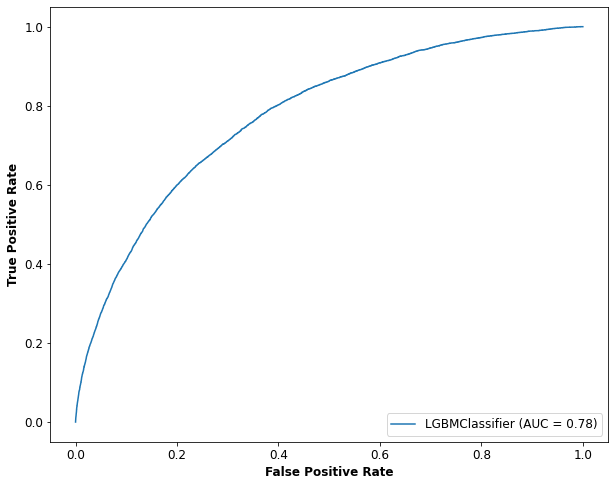

In [38]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                         "figure.figsize":[10,8], "savefig.bbox":"tight"})
plot_roc_curve(clf, X_test, y_test)
plt.show()

In [39]:
df_feature_importance = pd.DataFrame()
df_feature_importance["feature"] = data.columns
df_feature_importance["occurences"] = clf.feature_importances_
df_feature_importance

,feature,occurences
0,NAME_CONTRACT_TYPE,19
1,CODE_GENDER,35
2,FLAG_OWN_CAR,0
3,FLAG_OWN_REALTY,1
4,CNT_CHILDREN,0
...,...,...
369,inst_NUM_INSTALMENT_NUMBER,22
370,inst_DAYS_INSTALMENT,7
371,inst_DAYS_ENTRY_PAYMENT,16
372,inst_AMT_INSTALMENT,4


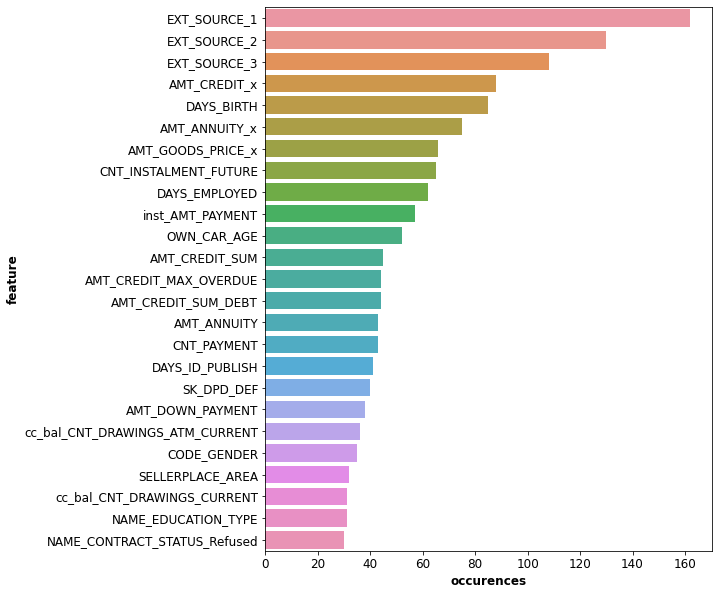

In [40]:
plt.figure(figsize=(8,10))
sns.barplot(x="occurences", y="feature", 
            data=df_feature_importance.sort_values(by="occurences", ascending=False)[:25])
plt.show()

In [41]:
df_homecredit[df_homecredit["Row"]=="AMT_CREDIT"]

,Unnamed: 0,Table,Row,Description,Special
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN


In [42]:
df_feature_importance.sort_values(by="occurences", ascending=False)[:25]

,feature,occurences
39,EXT_SOURCE_1,162
40,EXT_SOURCE_2,130
41,EXT_SOURCE_3,108
6,AMT_CREDIT_x,88
15,DAYS_BIRTH,85
7,AMT_ANNUITY_x,75
8,AMT_GOODS_PRICE_x,66
329,CNT_INSTALMENT_FUTURE,65
16,DAYS_EMPLOYED,62
373,inst_AMT_PAYMENT,57
